## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l1_l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4, l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1_ratio, l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1_ratio, l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-4, 1e-4, 1e-8, 1e-8]
L2_EXP = [1e-4, 1e-8, 1e-4, 1e-8]

In [7]:
results = {}

for i in range(4):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f, %.6f" % (L1_EXP[i], L2_EXP[i]))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=L1_EXP[i], l2_ratio=L2_EXP[i])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM) 
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-%s_%s" % (L1_EXP[i], L2_EXP[i])
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with Regulizer = 0.000100, 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/5

50000/50000 [==============================] - 7s 134us/step - loss: 2.6847 - accuracy: 0.6227 - val_loss: 3.1100 - val_accuracy: 0.4787
Epoch 49/50
50000/50000 [==============================] - 7s 134us/step - loss: 2.6466 - accuracy: 0.6246 - val_loss: 2.8774 - val_accuracy: 0.5297
Epoch 50/50
50000/50000 [==============================] - 7s 134us/step - loss: 2.6102 - accuracy: 0.6249 - val_loss: 2.9757 - val_accuracy: 0.5045
Experiment with Regulizer = 0.000100, 0.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_______________________________________

50000/50000 [==============================] - 7s 133us/step - loss: 2.8330 - accuracy: 0.6163 - val_loss: 3.0433 - val_accuracy: 0.5381
Epoch 46/50
50000/50000 [==============================] - 7s 132us/step - loss: 2.7896 - accuracy: 0.6221 - val_loss: 3.0065 - val_accuracy: 0.5373
Epoch 47/50
50000/50000 [==============================] - 7s 132us/step - loss: 2.7484 - accuracy: 0.6232 - val_loss: 2.9966 - val_accuracy: 0.5263
Epoch 48/50
50000/50000 [==============================] - 7s 132us/step - loss: 2.7156 - accuracy: 0.6239 - val_loss: 3.0116 - val_accuracy: 0.5185
Epoch 49/50
50000/50000 [==============================] - 7s 132us/step - loss: 2.6746 - accuracy: 0.6252 - val_loss: 2.9961 - val_accuracy: 0.5178
Epoch 50/50
50000/50000 [==============================] - 7s 133us/step - loss: 2.6341 - accuracy: 0.6294 - val_loss: 2.9239 - val_accuracy: 0.5256
Experiment with Regulizer = 0.000000, 0.000100
Model: "model_1"
______________________________________________________

50000/50000 [==============================] - 7s 135us/step - loss: 1.1317 - accuracy: 0.6515 - val_loss: 1.4922 - val_accuracy: 0.5323
Epoch 43/50
50000/50000 [==============================] - 7s 136us/step - loss: 1.1149 - accuracy: 0.6594 - val_loss: 1.5005 - val_accuracy: 0.5295
Epoch 44/50
50000/50000 [==============================] - 7s 136us/step - loss: 1.1071 - accuracy: 0.6611 - val_loss: 1.5229 - val_accuracy: 0.5235
Epoch 45/50
50000/50000 [==============================] - 7s 135us/step - loss: 1.0909 - accuracy: 0.6688 - val_loss: 1.5317 - val_accuracy: 0.5277
Epoch 46/50
50000/50000 [==============================] - 7s 137us/step - loss: 1.0848 - accuracy: 0.6693 - val_loss: 1.5761 - val_accuracy: 0.5155
Epoch 47/50
50000/50000 [==============================] - 7s 136us/step - loss: 1.0713 - accuracy: 0.6748 - val_loss: 1.6113 - val_accuracy: 0.5188
Epoch 48/50
50000/50000 [==============================] - 7s 135us/step - loss: 1.0579 - accuracy: 0.6806 - val_loss:

50000/50000 [==============================] - 7s 135us/step - loss: 0.9989 - accuracy: 0.6494 - val_loss: 1.3634 - val_accuracy: 0.5249
Epoch 40/50
50000/50000 [==============================] - 7s 135us/step - loss: 0.9869 - accuracy: 0.6541 - val_loss: 1.3412 - val_accuracy: 0.5307
Epoch 41/50
50000/50000 [==============================] - 7s 136us/step - loss: 0.9721 - accuracy: 0.6616 - val_loss: 1.3605 - val_accuracy: 0.5337
Epoch 42/50
50000/50000 [==============================] - 7s 135us/step - loss: 0.9623 - accuracy: 0.6643 - val_loss: 1.3574 - val_accuracy: 0.5389
Epoch 43/50
50000/50000 [==============================] - 7s 135us/step - loss: 0.9499 - accuracy: 0.6667 - val_loss: 1.4363 - val_accuracy: 0.5106
Epoch 44/50
50000/50000 [==============================] - 7s 135us/step - loss: 0.9366 - accuracy: 0.6723 - val_loss: 1.3977 - val_accuracy: 0.5257
Epoch 45/50
50000/50000 [==============================] - 7s 135us/step - loss: 0.9254 - accuracy: 0.6750 - val_loss:

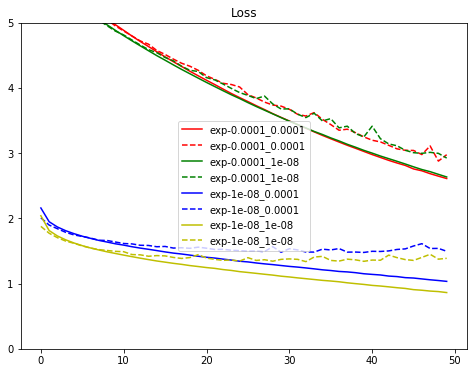

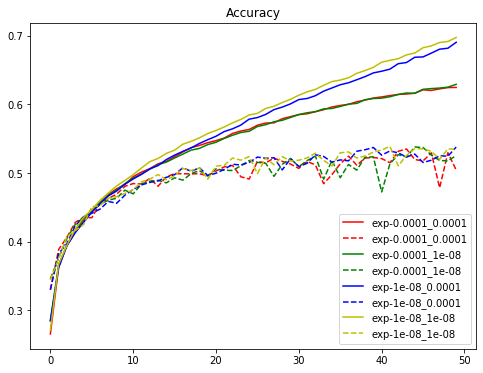

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()